# Batch vs. Iterative Analysis

1. Exploratory Data Analysis
2. B1-B5 tests: Overall effect and Model-specific effects
3. MO1-MO9 tests: Moderation (usage type×3, complexity×2, NUTS×2, source×2)
4. IC1-IC6 tests: Intercorrelations (Spearman×3, χ²×3)
5. Visualizations
6. Summary

In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, wilcoxon, spearmanr, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import multipletests

warnings.filterwarnings('ignore')

df_origin = pd.read_csv('../../data/cleaned_data/data_batch_iterative.csv')

df_origin.sample(5)

,answer_id,model_name,provider_country,licence_type,map_code,graphical_complexity,viz_technique,symbol_scaling,diagram_structure,map_source,question_id,nuts_level,map_usage_type,task_type,test_mode,score
440,585,Gemini 1.5 Pro,USA,paid,SINGLE-G-ATL-1,low,choropleth,NaN,NaN,atlas,9,country,interpretation,predict,iterative,0.0
15,16,GPT-4o,USA,paid,SINGLE-G-ATL-2,low,cartogram,NaN,NaN,atlas,16,country,interpretation,interpret,batch,0.0
850,1283,Claude 3.7 Sonnet,USA,paid,MULTI-D-ATL-2,high,NaN,proportional symbols,structural,atlas,131,region,analysis,cluster,iterative,4.0
464,609,Gemini 1.5 Pro,USA,paid,SINGLE-D-ATL-1,low,cartogram,NaN,NaN,atlas,33,region,analysis,associate,iterative,5.0
319,464,Gemini 1.5 Pro,USA,paid,SINGLE-D-ATL-1,low,cartogram,NaN,NaN,atlas,32,region,analysis,cluster,batch,4.5


## 1. Exploratory Data Analysis

In [2]:
print("1. BASIC INFORMATION")
print("-" * 80)
print(f"Total observations: {len(df_origin)}")
print(f"Unique questions: {df_origin['question_id'].nunique()}")
print(f"Models: {', '.join(df_origin['model_name'].unique())}")
print(f"Test modes: {', '.join(df_origin['test_mode'].unique())}")

mode_counts = df_origin['test_mode'].value_counts()
print(f"\nObservations per mode:")
print(mode_counts)

1. BASIC INFORMATION
--------------------------------------------------------------------------------
Total observations: 1152
Unique questions: 144
Models: GPT-4o, Gemini 1.5 Pro, Claude 3.7 Sonnet, DeepSeek-R1
Test modes: batch, iterative

Observations per mode:
test_mode
batch        576
iterative    576
Name: count, dtype: int64


In [3]:
print("2. ZERO VALUES ANALYSIS")
print("-" * 80)
zeros_total = (df_origin['score'] == 0).sum()
zeros_pct = (zeros_total / len(df_origin)) * 100
print(f"Zero values: {zeros_total} ({zeros_pct:.2f}%)")
print("\nNote: Zeros represent failed responses, not missing data.")
print("All analyses include zeros as legitimate failure outcomes.")

2. ZERO VALUES ANALYSIS
--------------------------------------------------------------------------------
Zero values: 327 (28.39%)

Note: Zeros represent failed responses, not missing data.
All analyses include zeros as legitimate failure outcomes.


In [4]:
print("3. DESCRIPTIVE STATISTICS")
print("-" * 80)
for mode in ['batch', 'iterative']:
    mode_data = df_origin[df_origin['test_mode'] == mode]['score']
    print(f"\n{mode.upper()}:")
    print(f"  M = {mode_data.mean():.3f}, SD = {mode_data.std():.3f}")
    print(f"  Mdn = {mode_data.median():.3f}")
    print(f"  Range: [{mode_data.min():.1f}, {mode_data.max():.1f}]")

3. DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------

BATCH:
  M = 3.251, SD = 1.983
  Mdn = 4.200
  Range: [0.0, 5.0]

ITERATIVE:
  M = 3.031, SD = 2.091
  Mdn = 4.200
  Range: [0.0, 5.0]


In [5]:
print("4. DISTRIBUTION TESTS")
print("-" * 80)
for mode in ['batch', 'iterative']:
    mode_data = df_origin[df_origin['test_mode'] == mode]['score']
    stat, p = shapiro(mode_data)
    print(f"{mode}: W = {stat:.4f}, p < .001 (non-normal)")

4. DISTRIBUTION TESTS
--------------------------------------------------------------------------------
batch: W = 0.7308, p < .001 (non-normal)
iterative: W = 0.7254, p < .001 (non-normal)


In [6]:
print("Conclusion: Non-parametric tests required (Wilcoxon signed-rank)")

Conclusion: Non-parametric tests required (Wilcoxon signed-rank)


## 2. Overall effect and model-specific effects

In [7]:
# Prepare paired data
df_paired = df_origin.pivot_table(
    values='score',
    index=['question_id', 'model_name'],
    columns='test_mode',
    aggfunc='first'
).reset_index()

df_paired['difference'] = df_paired['batch'] - df_paired['iterative']

print(f"\nPaired observations: {len(df_paired)}")
print(f"Difference M = {df_paired['difference'].mean():.4f}, SD = {df_paired['difference'].std():.4f}")


Paired observations: 576
Difference M = 0.2193, SD = 2.1106


In [8]:
# Overall Wilcoxon test
stat_overall, p_overall = wilcoxon(
    df_paired['batch'],
    df_paired['iterative'],
    alternative='two-sided',
    zero_method='wilcox'
)

# Model-specific tests
model_stats = []
for model in df_paired['model_name'].unique():
    model_data = df_paired[df_paired['model_name'] == model]
    stat, p = wilcoxon(
        model_data['batch'],
        model_data['iterative'],
        alternative='two-sided',
        zero_method='wilcox'
    )
    model_stats.append({
        'Model': model,
        'N': len(model_data),
        'Mean_diff': model_data['difference'].mean(),
        'p_uncorrected': p
    })

# Apply FDR correction (Benjamini-Hochberg)
all_p_values = [p_overall] + [m['p_uncorrected'] for m in model_stats]
test_names = ['Overall'] + [m['Model'] for m in model_stats]

rejected, p_corrected, _, _ = multipletests(
    all_p_values,
    alpha=0.05,
    method='fdr_bh'
)

In [9]:
print("1. WILCOXON SIGNED-RANK TESTS")
print("-" * 80)

print("\n1.1 Overall Effect")
# B1: Overall Effect
# H0: There is no difference in scores between Batch and Iterative modes (median difference = 0)
# H1: There is a difference in scores between Batch and Iterative modes (median difference ≠ 0)
print(f"  W = {stat_overall}, p_uncorrected = {p_overall:.6f}")
print(f"  p_corrected (FDR) = {p_corrected[0]:.6f}")
print(f"  Significant after correction: {'YES' if rejected[0] else 'NO'}")

print("\n1.2 Model-Specific Effects")
# Model-Specific Effects
# B2: Claude 3.7 Sonnet effect
# B3: DeepSeek-R1 effect
# B4: GPT-4o effect
# B5: Gemini 1.5 Pro effect

# H0: No difference in scores between Batch and Iterative for this model
# H1: Scores differ between Batch and Iterative for this model

for i, model_stat in enumerate(model_stats):
    model_stat['p_corrected'] = p_corrected[i + 1]
    model_stat['significant'] = rejected[i + 1]

    print(f"\n{model_stat['Model']}:")
    print(f"  N = {model_stat['N']}, Mean diff = {model_stat['Mean_diff']:.3f}")
    print(f"  p_uncorrected = {model_stat['p_uncorrected']:.6f}")
    print(f"  p_corrected (FDR) = {model_stat['p_corrected']:.6f}")
    print(f"  Significant: {'YES' if model_stat['significant'] else 'NO'}")

1. WILCOXON SIGNED-RANK TESTS
--------------------------------------------------------------------------------

1.1 Overall Effect
  W = 41903.5, p_uncorrected = 0.042816
  p_corrected (FDR) = 0.071359
  Significant after correction: NO

1.2 Model-Specific Effects

Claude 3.7 Sonnet:
  N = 144, Mean diff = 0.377
  p_uncorrected = 0.007284
  p_corrected (FDR) = 0.036421
  Significant: YES

DeepSeek-R1:
  N = 144, Mean diff = 0.067
  p_uncorrected = 0.980570
  p_corrected (FDR) = 0.980570
  Significant: NO

GPT-4o:
  N = 144, Mean diff = 0.307
  p_uncorrected = 0.034254
  p_corrected (FDR) = 0.071359
  Significant: NO

Gemini 1.5 Pro:
  N = 144, Mean diff = 0.127
  p_uncorrected = 0.812571
  p_corrected (FDR) = 0.980570
  Significant: NO


In [10]:
# Effect sizes with bootstrap confidence intervals
print("\n2. EFFECT SIZES WITH CONFIDENCE INTERVALS")
print("-" * 80)

def rank_biserial_correlation(x, y):
    differences = x - y
    non_zero_diff = differences[differences != 0]
    if len(non_zero_diff) == 0:
        return 0.0
    positive_ranks = (non_zero_diff > 0).sum()
    negative_ranks = (non_zero_diff < 0).sum()
    return (positive_ranks - negative_ranks) / (positive_ranks + negative_ranks)


def bootstrap_ci(x, y, func, n_bootstrap=5000, ci=95):
    np.random.seed(42)
    bootstrap_stats = []
    n = len(x)

    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        bootstrap_stats.append(func(x[idx], y[idx]))

    lower = np.percentile(bootstrap_stats, (100 - ci) / 2)
    upper = np.percentile(bootstrap_stats, 100 - (100 - ci) / 2)
    return lower, upper


# Overall effect size
r_overall = rank_biserial_correlation(df_paired['batch'].values, df_paired['iterative'].values)
ci_lower, ci_upper = bootstrap_ci(
    df_paired['batch'].values,
    df_paired['iterative'].values,
    rank_biserial_correlation
)

print("\n2.1 Overall Effect Size")
print(f"  Rank-biserial r = {r_overall:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")


if abs(r_overall) < 0.1:
    interpretation = "negligible"
elif abs(r_overall) < 0.3:
    interpretation = "small"
elif abs(r_overall) < 0.5:
    interpretation = "medium"
else:
    interpretation = "large"
print(f"  Interpretation: {interpretation} effect")

# Model-specific effect sizes
print("\n2.2 Model-Specific Effect Sizes")
for model_stat in model_stats:
    model_data = df_paired[df_paired['model_name'] == model_stat['Model']]
    r = rank_biserial_correlation(model_data['batch'].values, model_data['iterative'].values)
    ci_l, ci_u = bootstrap_ci(
        model_data['batch'].values,
        model_data['iterative'].values,
        rank_biserial_correlation
    )
    model_stat['effect_size'] = r
    model_stat['ci_lower'] = ci_l
    model_stat['ci_upper'] = ci_u

    print(f"\n{model_stat['Model']}:")
    print(f"  r = {r:.3f}, 95% CI [{ci_l:.3f}, {ci_u:.3f}]")


2. EFFECT SIZES WITH CONFIDENCE INTERVALS
--------------------------------------------------------------------------------

2.1 Overall Effect Size
  Rank-biserial r = 0.161, 95% CI [0.068, 0.254]
  Interpretation: small effect

2.2 Model-Specific Effect Sizes

Claude 3.7 Sonnet:
  r = 0.385, 95% CI [0.217, 0.554]

DeepSeek-R1:
  r = 0.044, 95% CI [-0.140, 0.221]

GPT-4o:
  r = 0.235, 95% CI [0.042, 0.423]

Gemini 1.5 Pro:
  r = -0.039, 95% CI [-0.234, 0.155]


## 3. Moderation Analysis

In [11]:
print("1. SIMPLE EFFECTS BY MODERATOR (FDR CORRECTED)")
print("-" * 80)

# Test by map usage type
# MO1: Reading effect
# MO2: Analysis effect
# MO3: Interpretation effect

# H0: No difference in scores between Batch and Iterative within this map usage type
# H1: Scores differ between Batch and Iterative within this map usage type

category_tests = []
for cat in df_origin['map_usage_type'].unique():
    cat_data = df_origin[df_origin['map_usage_type'] == cat]
    cat_paired = cat_data.pivot_table(
        values='score',
        index='question_id',
        columns='test_mode',
        aggfunc='first'
    ).dropna()

    if len(cat_paired) > 0:
        stat, p = wilcoxon(cat_paired['batch'], cat_paired['iterative'], alternative='two-sided')
        category_tests.append({
            'Category': cat,
            'N': len(cat_paired),
            'Mean_diff': (cat_paired['batch'] - cat_paired['iterative']).mean(),
            'p_uncorrected': p
        })

# Apply FDR correction
cat_p_values = [t['p_uncorrected'] for t in category_tests]
_, cat_p_corrected, _, _ = multipletests(cat_p_values, alpha=0.05, method='fdr_bh')

print("By Map Usage Type")
for i, test in enumerate(category_tests):
    test['p_corrected'] = cat_p_corrected[i]
    print(f"\n{test['Category']}:")
    print(f"  N = {test['N']}, Mean diff = {test['Mean_diff']:.3f}")
    print(f"  p_corrected = {test['p_corrected']:.6f}")

1. SIMPLE EFFECTS BY MODERATOR (FDR CORRECTED)
--------------------------------------------------------------------------------
By Map Usage Type

reading:
  N = 48, Mean diff = 0.292
  p_corrected = 0.148510

analysis:
  N = 48, Mean diff = 0.457
  p_corrected = 0.089164

interpretation:
  N = 48, Mean diff = 0.172
  p_corrected = 0.963795


In [12]:
# Test by graphical complexity
# MO4: Low complexity effect
# MO5: High complexity effect

# H0: No difference in scores between Batch and Iterative within this graphical complexity
# H1: Scores differ between Batch and Iterative within this graphical complexity

print("By Graphical Complexity")

complexity_tests = []
for comp in df_origin['graphical_complexity'].unique():
    comp_data = df_origin[df_origin['graphical_complexity'] == comp]
    comp_paired = comp_data.pivot_table(
        values='score',
        index='question_id',
        columns='test_mode',
        aggfunc='first'
    ).dropna()

    if len(comp_paired) > 0:
        stat, p = wilcoxon(comp_paired['batch'], comp_paired['iterative'], alternative='two-sided')
        complexity_tests.append({
            'Graphical Complexity': comp,
            'N': len(comp_paired),
            'Mean_diff': (comp_paired['batch'] - comp_paired['iterative']).mean(),
            'p_uncorrected': p
        })

comp_p_values = [t['p_uncorrected'] for t in complexity_tests]
_, comp_p_corrected, _, _ = multipletests(comp_p_values, alpha=0.05, method='fdr_bh')

print("\n1.2 By Graphical Complexity")
for i, test in enumerate(complexity_tests):
    test['p_corrected'] = comp_p_corrected[i]
    print(f"\n{test['Graphical Complexity']}:")
    print(f"  N = {test['N']}, Mean diff = {test['Mean_diff']:.3f}")
    print(f"  p_corrected = {test['p_corrected']:.6f}")

By Graphical Complexity

1.2 By Graphical Complexity

low:
  N = 72, Mean diff = 0.604
  p_corrected = 0.016047

high:
  N = 72, Mean diff = 0.010
  p_corrected = 0.670908


In [13]:
# Test by spatial aggregation level (country/region)
# MO6: Country level effect
# MO7: Region level effect

# H0: No difference in scores between Batch and Iterative within this spatial aggregation level
# H1: Scores differ between Batch and Iterative within this spatial aggregation level

print("By Spatial Aggregation Level (NUTS)")
nuts_tests = []
for nuts in df_origin['nuts_level'].unique():
    nuts_data = df_origin[df_origin['nuts_level'] == nuts]
    nuts_paired = nuts_data.pivot_table(
        values='score',
        index='question_id',
        columns='test_mode',
        aggfunc='first'
    ).dropna()

    if len(nuts_paired) > 0:
        stat, p = wilcoxon(nuts_paired['batch'], nuts_paired['iterative'], alternative='two-sided')
        nuts_tests.append({
            'NUTS_Level': nuts,
            'N': len(nuts_paired),
            'Mean_diff': (nuts_paired['batch'] - nuts_paired['iterative']).mean(),
            'p_uncorrected': p
        })

# Apply FDR correction
nuts_p_values = [t['p_uncorrected'] for t in nuts_tests]
_, nuts_p_corrected, _, _ = multipletests(nuts_p_values, alpha=0.05, method='fdr_bh')

for i, test in enumerate(nuts_tests):
    test['p_corrected'] = nuts_p_corrected[i]
    print(f"\n{test['NUTS_Level']}:")
    print(f"  N = {test['N']}, Mean diff = {test['Mean_diff']:.3f}")
    print(f"  p_corrected = {test['p_corrected']:.6f}")

By Spatial Aggregation Level (NUTS)

country:
  N = 72, Mean diff = 0.537
  p_corrected = 0.015927

region:
  N = 72, Mean diff = 0.076
  p_corrected = 0.785688


In [14]:
# Test by map source (atlas/institution)
# MO8: Atlas effect
# MO9: Institution effect

# H0: No difference in scores between Batch and Iterative within this map source
# H1: Scores differ between Batch and Iterative within this map source

print("By Map Source")
origin_tests = []
for orig in df_origin['map_source'].unique():
    orig_data = df_origin[df_origin['map_source'] == orig]
    orig_paired = orig_data.pivot_table(
        values='score',
        index='question_id',
        columns='test_mode',
        aggfunc='first'
    ).dropna()

    if len(orig_paired) > 0:
        stat, p = wilcoxon(orig_paired['batch'], orig_paired['iterative'], alternative='two-sided')
        origin_tests.append({
            'Map Source': orig,
            'N': len(orig_paired),
            'Mean_diff': (orig_paired['batch'] - orig_paired['iterative']).mean(),
            'p_uncorrected': p
        })

# Apply FDR correction
orig_p_values = [t['p_uncorrected'] for t in origin_tests]
_, orig_p_corrected, _, _ = multipletests(orig_p_values, alpha=0.05, method='fdr_bh')

for i, test in enumerate(origin_tests):
    test['p_corrected'] = orig_p_corrected[i]
    print(f"\n{test['Map Source']}:")
    print(f"  N = {test['N']}, Mean diff = {test['Mean_diff']:.3f}")
    print(f"  p_corrected = {test['p_corrected']:.6f}")

By Map Source

atlas:
  N = 72, Mean diff = 0.525
  p_corrected = 0.064576

statistical_office:
  N = 72, Mean diff = 0.089
  p_corrected = 0.422776


## 3.Intercorrelation Analysis

In [15]:
print("MODERATOR INTERCORRELATIONS")
print("-" * 80)

# Create a subset with one row per question (not duplicated by model)
df_question_level = df_origin.drop_duplicates(subset='question_id')[
    ['question_id', 'graphical_complexity', 'map_source', 'nuts_level']
].copy()

le_complexity = LabelEncoder()
le_origin = LabelEncoder()
le_nuts = LabelEncoder()

df_question_level['complexity_num'] = le_complexity.fit_transform(df_question_level['graphical_complexity'])
df_question_level['source_num'] = le_origin.fit_transform(df_question_level['map_source'])
df_question_level['nuts_num'] = le_nuts.fit_transform(df_question_level['nuts_level'])

print("Spearman Rank Correlations")
print("-" * 40)

# Correlations Between Moderators
# IC1: Spearman: Complexity × Map Source
# IC2: Spearman: Complexity × NUTS Level
# IC3: Spearman: Map Source × NUTS Level
# IC4: Chi-square: Complexity × Map Source
# IC5: Chi-square: Complexity × NUTS Level
# IC6: Chi-square: Map Source × NUTS Level

# H0: No monotonic relationship between the two moderators
# H1: A monotonic relationship exists between the two moderators

moderators = {
    'Complexity': df_question_level['complexity_num'],
    'Map Source': df_question_level['source_num'],
    'NUTS Level': df_question_level['nuts_num']
}

corr_results = []
for name1, var1 in moderators.items():
    for name2, var2 in moderators.items():
        if name1 < name2:  # Avoid duplicates
            rho, p = spearmanr(var1, var2)
            corr_results.append({
                'Variable 1': name1,
                'Variable 2': name2,
                'Spearman rho': rho,
                'p-value': p
            })
            print(f"\n{name1} × {name2}:")
            print(f"  ρ = {rho:.3f}, p = {p:.4f}")
            if abs(rho) < 0.3:
                strength = "weak"
            elif abs(rho) < 0.6:
                strength = "moderate"
            else:
                strength = "strong"
            print(f"  Interpretation: {strength} correlation")

MODERATOR INTERCORRELATIONS
--------------------------------------------------------------------------------
Spearman Rank Correlations
----------------------------------------

Complexity × Map Source:
  ρ = 0.250, p = 0.0025
  Interpretation: weak correlation

Complexity × NUTS Level:
  ρ = 0.250, p = 0.0025
  Interpretation: weak correlation

Map Source × NUTS Level:
  ρ = 0.000, p = 1.0000
  Interpretation: weak correlation


In [16]:
# Chi-square tests for categorical associations
print("Chi-Square Tests of Independence")
print("-" * 40)

# B18: Associations Between Categorical Moderators
# H0: Variables are independent
# H1: Variables are associated

categorical_pairs = [
    ('graphical_complexity', 'map_source'),
    ('graphical_complexity', 'nuts_level'),
    ('map_source', 'nuts_level')
]

for var1, var2 in categorical_pairs:
    contingency_table = pd.crosstab(
        df_question_level[var1],
        df_question_level[var2]
    )
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Cramér's V for effect size
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim))

    print(f"\n{var1} × {var2}:")
    print(f"  χ² = {chi2:.3f}, df = {dof}, p = {p:.4f}")
    print(f"  Cramér's V = {cramers_v:.3f}")
    print(f"  Association: {'YES' if p < 0.05 else 'NO'}")
    print("\n  Contingency table:")
    print(contingency_table)

Chi-Square Tests of Independence
----------------------------------------

graphical_complexity × map_source:
  χ² = 8.028, df = 1, p = 0.0046
  Cramér's V = 0.236
  Association: YES

  Contingency table:
map_source            atlas  statistical_office
graphical_complexity                           
high                     45                  27
low                      27                  45

graphical_complexity × nuts_level:
  χ² = 8.028, df = 1, p = 0.0046
  Cramér's V = 0.236
  Association: YES

  Contingency table:
nuts_level            country  region
graphical_complexity                 
high                       45      27
low                        27      45

map_source × nuts_level:
  χ² = 0.000, df = 1, p = 1.0000
  Cramér's V = 0.000
  Association: NO

  Contingency table:
nuts_level          country  region
map_source                         
atlas                    36      36
statistical_office       36      36


## 5. Visualizations

VISUALIZATIONS


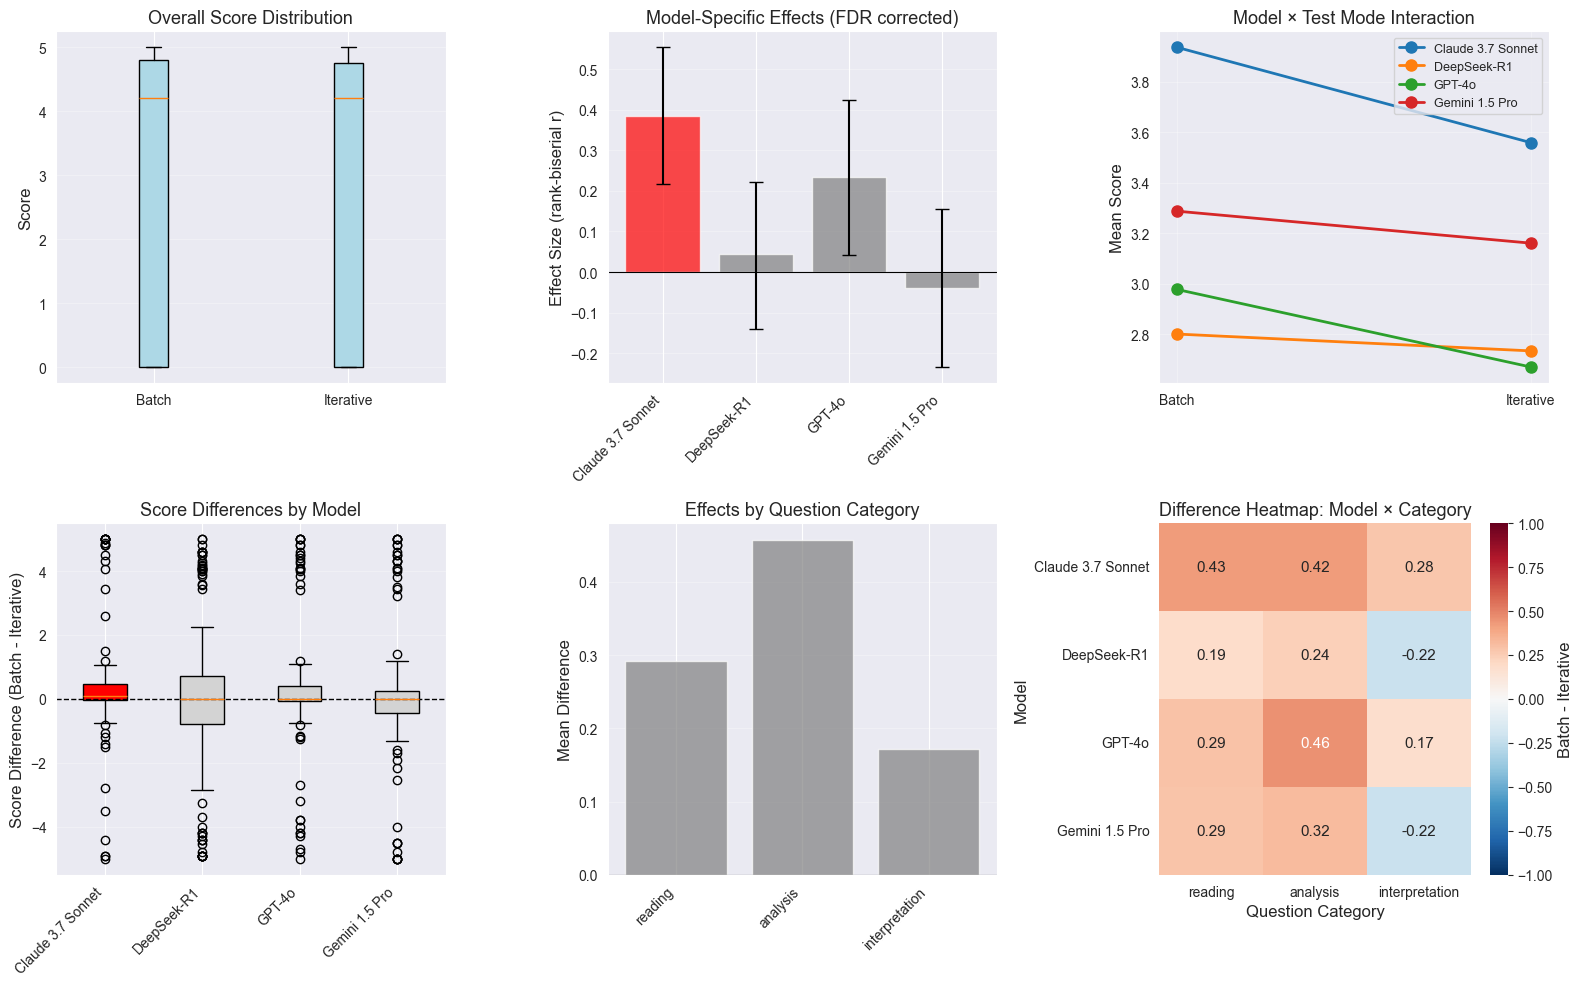

In [17]:
print("VISUALIZATIONS")
print("=" * 80)

plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})

# Main figure
fig = plt.figure(figsize=(16, 10))

# 1. Overall distribution
ax1 = plt.subplot(2, 3, 1)
bp = ax1.boxplot([df_origin[df_origin['test_mode'] == 'batch']['score'],
                  df_origin[df_origin['test_mode'] == 'iterative']['score']],
                 labels=['Batch', 'Iterative'],
                 patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax1.set_ylabel('Score')
ax1.set_title('Overall Score Distribution')
ax1.grid(axis='y', alpha=0.3)

# 2. Model-specific effects
ax2 = plt.subplot(2, 3, 2)
model_names = [m['Model'] for m in model_stats]
effect_sizes = [m['effect_size'] for m in model_stats]
ci_lowers = [m['ci_lower'] for m in model_stats]
ci_uppers = [m['ci_upper'] for m in model_stats]
colors = ['red' if m['significant'] else 'gray' for m in model_stats]

x_pos = np.arange(len(model_names))
ax2.bar(x_pos, effect_sizes, color=colors, alpha=0.7)
ax2.errorbar(x_pos, effect_sizes,
             yerr=[np.array(effect_sizes) - np.array(ci_lowers),
                   np.array(ci_uppers) - np.array(effect_sizes)],
             fmt='none', color='black', capsize=5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylabel('Effect Size (rank-biserial r)')
ax2.set_title('Model-Specific Effects (FDR corrected)')
ax2.grid(axis='y', alpha=0.3)

# 3. Interaction plot: Model × Mode
ax3 = plt.subplot(2, 3, 3)
interaction_data = df_origin.groupby(['model_name', 'test_mode'])['score'].mean().unstack()
for model in interaction_data.index:
    ax3.plot(['Batch', 'Iterative'],
             [interaction_data.loc[model, 'batch'], interaction_data.loc[model, 'iterative']],
             marker='o', linewidth=2, markersize=8, label=model)
ax3.set_ylabel('Mean Score')
ax3.set_title('Model × Test Mode Interaction')
ax3.legend(loc='best', fontsize=9)
ax3.grid(alpha=0.3)

# 4. Paired differences by model
ax4 = plt.subplot(2, 3, 4)
diff_by_model = [df_paired[df_paired['model_name'] == m]['difference'].values
                 for m in model_names]
bp2 = ax4.boxplot(diff_by_model, labels=model_names, patch_artist=True)
for i, patch in enumerate(bp2['boxes']):
    patch.set_facecolor('red' if model_stats[i]['significant'] else 'lightgray')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xticklabels(model_names, rotation=45, ha='right')
ax4.set_ylabel('Score Difference (Batch - Iterative)')
ax4.set_title('Score Differences by Model')
ax4.grid(axis='y', alpha=0.3)

# 5. Category effects
ax5 = plt.subplot(2, 3, 5)
cat_names = [t['Category'] for t in category_tests]
cat_diffs = [t['Mean_diff'] for t in category_tests]
colors_cat = ['red' if t['p_corrected'] < 0.05 else 'gray' for t in category_tests]
ax5.bar(range(len(cat_names)), cat_diffs, color=colors_cat, alpha=0.7)
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax5.set_xticks(range(len(cat_names)))
ax5.set_xticklabels(cat_names, rotation=45, ha='right')
ax5.set_ylabel('Mean Difference')
ax5.set_title('Effects by Question Category')
ax5.grid(axis='y', alpha=0.3)

# 6. Heatmap: Model × Category
ax6 = plt.subplot(2, 3, 6)
pivot_diff = df_origin.pivot_table(
    values='score',
    index='model_name',
    columns=['map_usage_type', 'test_mode'],
    aggfunc='mean'
)
diff_heatmap = pd.DataFrame()
for cat in df_origin['map_usage_type'].unique():
    if (cat, 'batch') in pivot_diff.columns and (cat, 'iterative') in pivot_diff.columns:
        diff_heatmap[cat] = pivot_diff[(cat, 'batch')] - pivot_diff[(cat, 'iterative')]

sns.heatmap(diff_heatmap, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax6, cbar_kws={'label': 'Batch - Iterative'}, vmin=-1, vmax=1)
ax6.set_title('Difference Heatmap: Model × Category')
ax6.set_xlabel('Question Category')
ax6.set_ylabel('Model')

plt.tight_layout()

In [18]:
def calculate_stats(data, groupby_cols):
    stats = data.groupby(groupby_cols)['score'].agg([
        ('mean', 'mean'),
        ('se', lambda x: x.std() / np.sqrt(len(x)))
    ]).reset_index()
    return stats

print("="*80)
print("GRAPHICAL COMPLEXITY INTERACTION DATA")
print("="*80)

complexity_stats = calculate_stats(df_origin, ['graphical_complexity', 'test_mode'])
print("\nRaw statistics:")
print(complexity_stats)

complexity_data = []
for complexity in ['low', 'high']:
    for mode in ['batch', 'iterative']:
        row = complexity_stats[(complexity_stats['graphical_complexity'] == complexity) &
                               (complexity_stats['test_mode'] == mode)]
        if not row.empty:
            complexity_data.append({
                'condition': f'{complexity.capitalize()}/{mode.capitalize()}',
                'mean': row['mean'].values[0],
                'se': row['se'].values[0]
            })

complexity_df = pd.DataFrame(complexity_data)
print("\nFormatted for plotting (Graphical Complexity):")
print(complexity_df)

print("\n" + "="*80)
print("NUTS LEVEL INTERACTION DATA")
print("="*80)

nuts_stats = calculate_stats(df_origin, ['nuts_level', 'test_mode'])
print("\nRaw statistics:")
print(nuts_stats)

nuts_data = []
for nuts in ['country', 'region']:
    for mode in ['batch', 'iterative']:
        row = nuts_stats[(nuts_stats['nuts_level'] == nuts) &
                        (nuts_stats['test_mode'] == mode)]
        if not row.empty:
            nuts_data.append({
                'condition': f'{nuts.capitalize()}/{mode.capitalize()}',
                'mean': row['mean'].values[0],
                'se': row['se'].values[0]
            })

nuts_df = pd.DataFrame(nuts_data)
print("\nFormatted for plotting (NUTS):")
print(nuts_df)

print("\n" + "="*80)
print("COMBINED INTERACTION DATA FOR PLOTTING")
print("="*80)

interaction_data = pd.concat([complexity_df, nuts_df], ignore_index=True)
print(interaction_data)

print("\n" + "="*80)
print("DATA READY FOR PLOT CODE:")
print("="*80)
print("\ninteraction_data = pd.DataFrame({")
print(f"    'condition': {interaction_data['condition'].tolist()},")
print(f"    'mean': {[round(x, 2) for x in interaction_data['mean'].tolist()]},")
print(f"    'se': {[round(x, 2) for x in interaction_data['se'].tolist()]}")
print("})")

print("\n" + "="*80)
print("DIFFERENCES (BATCH - ITERATIVE)")
print("="*80)

print("\nGraphical Complexity:")
for complexity in ['low', 'high']:
    batch_mean = complexity_stats[(complexity_stats['graphical_complexity'] == complexity) &
                                  (complexity_stats['test_mode'] == 'batch')]['mean'].values[0]
    iter_mean = complexity_stats[(complexity_stats['graphical_complexity'] == complexity) &
                                 (complexity_stats['test_mode'] == 'iterative')]['mean'].values[0]
    diff = batch_mean - iter_mean
    print(f"  {complexity.capitalize()}: Δ = {diff:.3f} (Batch: {batch_mean:.3f}, Iterative: {iter_mean:.3f})")

print("\nNUTS Level:")
for nuts in ['country', 'region']:
    batch_mean = nuts_stats[(nuts_stats['nuts_level'] == nuts) &
                            (nuts_stats['test_mode'] == 'batch')]['mean'].values[0]
    iter_mean = nuts_stats[(nuts_stats['nuts_level'] == nuts) &
                           (nuts_stats['test_mode'] == 'iterative')]['mean'].values[0]
    diff = batch_mean - iter_mean
    print(f"  {nuts.capitalize()}: Δ = {diff:.3f} (Batch: {batch_mean:.3f}, Iterative: {iter_mean:.3f})")

GRAPHICAL COMPLEXITY INTERACTION DATA

Raw statistics:
  graphical_complexity  test_mode      mean        se
0                 high      batch  2.986979  0.122332
1                 high  iterative  2.870747  0.127616
2                  low      batch  3.514583  0.109100
3                  low  iterative  3.192188  0.118162

Formatted for plotting (Graphical Complexity):
        condition      mean        se
0       Low/Batch  3.514583  0.109100
1   Low/Iterative  3.192188  0.118162
2      High/Batch  2.986979  0.122332
3  High/Iterative  2.870747  0.127616

NUTS LEVEL INTERACTION DATA

Raw statistics:
  nuts_level  test_mode      mean        se
0    country      batch  3.381424  0.113886
1    country  iterative  3.031771  0.120917
2     region      batch  3.120139  0.119431
3     region  iterative  3.031163  0.125727

Formatted for plotting (NUTS):
           condition      mean        se
0      Country/Batch  3.381424  0.113886
1  Country/Iterative  3.031771  0.120917
2       Region/B

## 6. Summarize

In [19]:
print("SUMMARY")
print("=" * 80)

print("\n1. MAIN FINDINGS (FDR CORRECTED)")
print("-" * 80)
print(f"Overall effect: {'SIGNIFICANT' if rejected[0] else 'NOT SIGNIFICANT'} (p_FDR = {p_corrected[0]:.3f})")
print(f"Effect size: r = {r_overall:.3f}, 95% CI [{float(ci_lower):.3f}, {float(ci_upper):.3f}] ({interpretation})")

print("\n2. MODEL-SPECIFIC EFFECTS")
print("-" * 80)
for m in model_stats:
    sig_str = "SIGNIFICANT" if m['significant'] else "NOT SIGNIFICANT"
    print(f"{m['Model']}: {sig_str} (p_FDR = {m['p_corrected']:.3f}), r = {m['effect_size']:.3f}")

print("\n3. METHODOLOGICAL NOTES")
print("-" * 80)
print("- Multiple comparison correction: FDR (Benjamini-Hochberg)")
print("- Effect size: Rank-biserial correlation with bootstrap 95% CI (n=5000)")
print("- Zero scores: Included as legitimate failure outcomes")
print("- Non-parametric tests used due to non-normal distributions")
print("- All 144 questions perfectly paired across modes")

print("\n4. INTERPRETATION")
print("-" * 80)
if rejected[0]:
    print("After FDR correction, a significant overall effect remains.")
else:
    print("After FDR correction, the overall effect is NOT significant.")

sig_models = [m['Model'] for m in model_stats if m['significant']]
if sig_models:
    print(f"Significant model-specific effects found for: {', '.join(sig_models)}")
else:
    print("No model-specific effects remain significant after correction.")

SUMMARY

1. MAIN FINDINGS (FDR CORRECTED)
--------------------------------------------------------------------------------
Overall effect: NOT SIGNIFICANT (p_FDR = 0.071)
Effect size: r = 0.161, 95% CI [0.068, 0.254] (small)

2. MODEL-SPECIFIC EFFECTS
--------------------------------------------------------------------------------
Claude 3.7 Sonnet: SIGNIFICANT (p_FDR = 0.036), r = 0.385
DeepSeek-R1: NOT SIGNIFICANT (p_FDR = 0.981), r = 0.044
GPT-4o: NOT SIGNIFICANT (p_FDR = 0.071), r = 0.235
Gemini 1.5 Pro: NOT SIGNIFICANT (p_FDR = 0.981), r = -0.039

3. METHODOLOGICAL NOTES
--------------------------------------------------------------------------------
- Multiple comparison correction: FDR (Benjamini-Hochberg)
- Effect size: Rank-biserial correlation with bootstrap 95% CI (n=5000)
- Zero scores: Included as legitimate failure outcomes
- Non-parametric tests used due to non-normal distributions
- All 144 questions perfectly paired across modes

4. INTERPRETATION
---------------------